In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

In [2]:
torch.manual_seed(0)

In [3]:
class ReLUOutputModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(hidden_dim, input_dim) * np.sqrt(2. / input_dim))
        self.b = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x):
        h = self.W @ x.T
        out = self.W.T @ F.relu(h + self.b[:, None])
        return out.T

In [4]:
def generate_dataset(n_samples, input_dim, sparsity=0.999):
    X = torch.zeros(n_samples, input_dim)
    for i in range(n_samples):
        mask = torch.rand(input_dim) > sparsity
        X[i, mask] = torch.rand(mask.sum())

        norm = X[i].norm(p=2)
        if norm > 0:
            X[i] = X[i] / norm
        else:
            X[i] = torch.randn(input_dim)
    return X

In [5]:
def compute_loss(model, X):
    with torch.no_grad():
        X_hat = model(X)
        loss = F.mse_loss(X_hat, X)
        return loss.item()

In [6]:
def plot_superposition(model, X, title_suffix="", device="cpu"):
    with torch.no_grad():
        X = X.to(device)
        features = model.W.detach().cpu().numpy()
        hidden = (model.W @ X.T).detach().cpu().numpy()

        plt.figure(figsize=(6, 6))
        plt.quiver(np.zeros(features.shape[1]), np.zeros(features.shape[1]),
                   features[0, :], features[1, :], color='blue', angles='xy', scale_units='xy', scale=1)

        plt.title(f"Features {title_suffix}")
        plt.axis('equal')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.quiver(np.zeros(X.shape[0]), np.zeros(X.shape[0]),
                   hidden[0, :], hidden[1, :], color='red', angles='xy', scale_units='xy', scale=1)

        plt.title(f"Hidden vectors {title_suffix}")
        plt.axis('equal')
        plt.grid(True)
        plt.show()

def plot_fractional_dimension(losses, dataset_sizes):
    plt.figure(figsize=(10, 4))
    plt.plot(dataset_sizes, losses, marker='o')
    plt.xscale('log')
    plt.xlabel('Dataset size')
    plt.ylabel('Test Loss')
    plt.title('Fractional dimension of features and training examples')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_parameter_norms(weight_norms, bias_norms, dataset_sizes):
    plt.figure(figsize=(10, 4))
    plt.plot(dataset_sizes, weight_norms, label='||W||', marker='o')
    plt.plot(dataset_sizes, bias_norms, label='||b||', marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Dataset size')
    plt.ylabel('Parameter norms')
    plt.title('Parameter norms during training')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 10000
hidden_dim = 2
dataset_sizes = [3, 5, 6, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000]#
weight_decay = 1e-2
learning_rate = 1e-3
warmup_steps = 2500
cosine_decay_steps = 50000

losses = []
weight_norms = []
bias_norms = []
selected_sizes = [3, 6, 10, 30, 100, 500, 2000, 10000]

X_test = generate_dataset(1000, input_dim).to(device)

Training epoch (size: 3): 100%|██████████| 50000/50000 [00:52<00:00, 951.11it/s] 


Dataset size: 3, Best Test Loss: 0.0010995403863489628


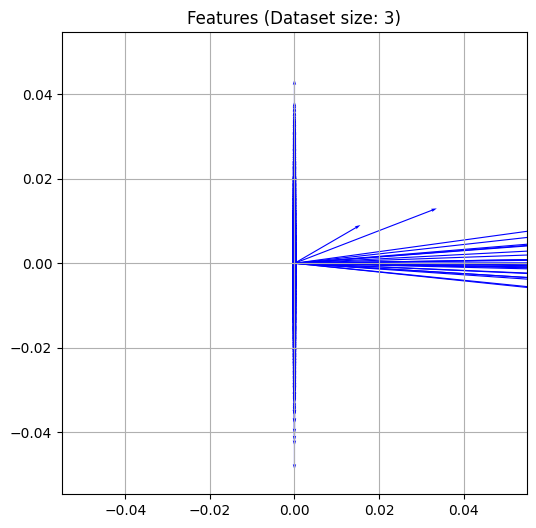

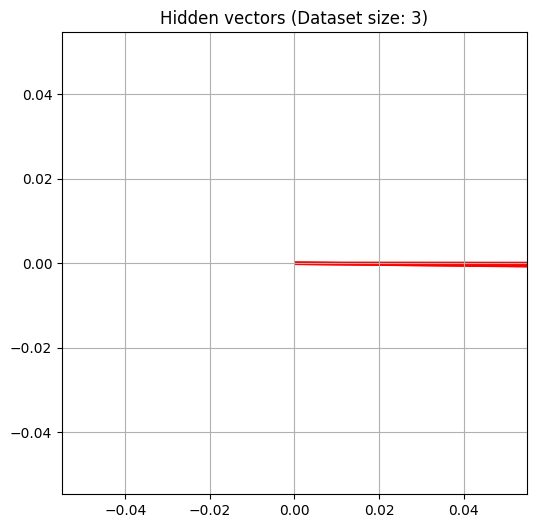

Training epoch (size: 5): 100%|██████████| 50000/50000 [00:54<00:00, 917.84it/s]


Dataset size: 5, Best Test Loss: 0.001103274174965918


Training epoch (size: 6): 100%|██████████| 50000/50000 [00:54<00:00, 920.67it/s]


Dataset size: 6, Best Test Loss: 0.001102591399103403


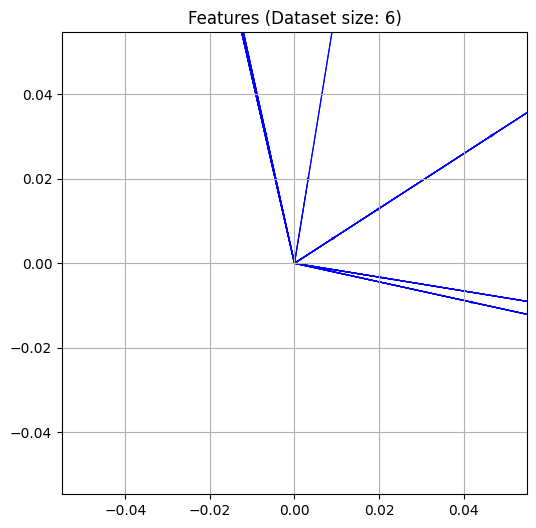

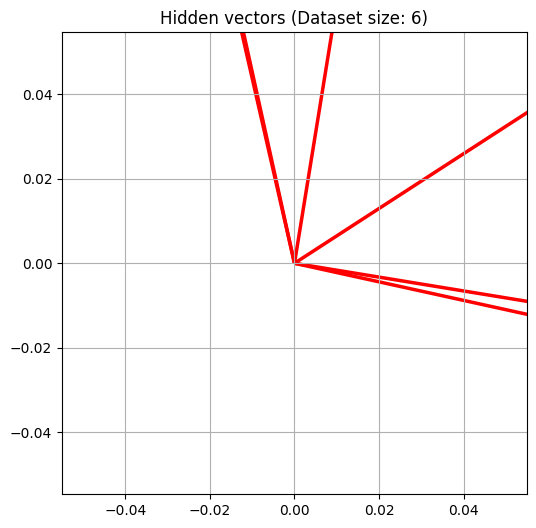

Training epoch (size: 8): 100%|██████████| 50000/50000 [00:54<00:00, 919.42it/s]


Dataset size: 8, Best Test Loss: 0.0011022472754120827


Training epoch (size: 10): 100%|██████████| 50000/50000 [00:53<00:00, 927.89it/s]


Dataset size: 10, Best Test Loss: 0.001101796398870647


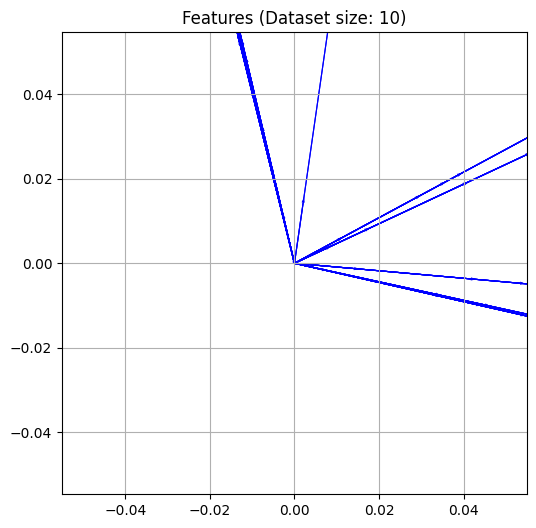

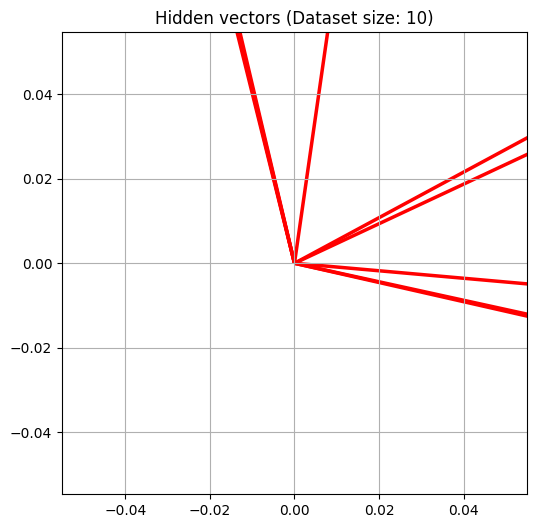

Training epoch (size: 15): 100%|██████████| 50000/50000 [00:54<00:00, 915.93it/s]


Dataset size: 15, Best Test Loss: 0.001101318746805191


Training epoch (size: 30): 100%|██████████| 50000/50000 [00:54<00:00, 912.49it/s]


Dataset size: 30, Best Test Loss: 0.001099989633075893


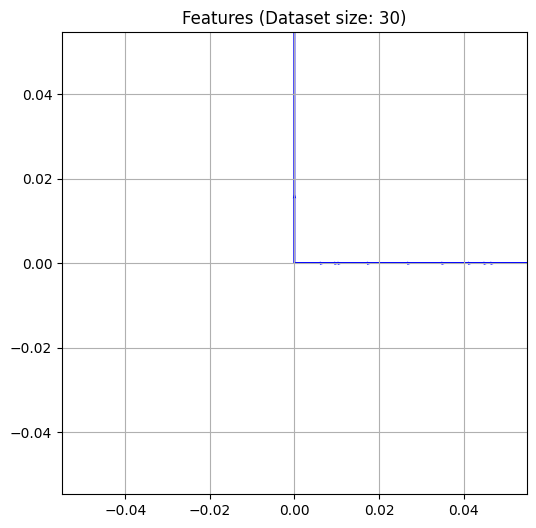

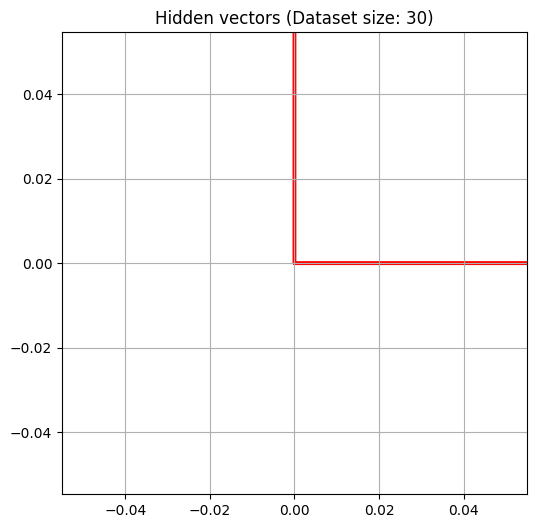

Training epoch (size: 50): 100%|██████████| 50000/50000 [00:54<00:00, 924.77it/s]


Dataset size: 50, Best Test Loss: 0.0010995655320584774


Training epoch (size: 100): 100%|██████████| 50000/50000 [00:57<00:00, 873.35it/s]


Dataset size: 100, Best Test Loss: 0.0010995694901794195


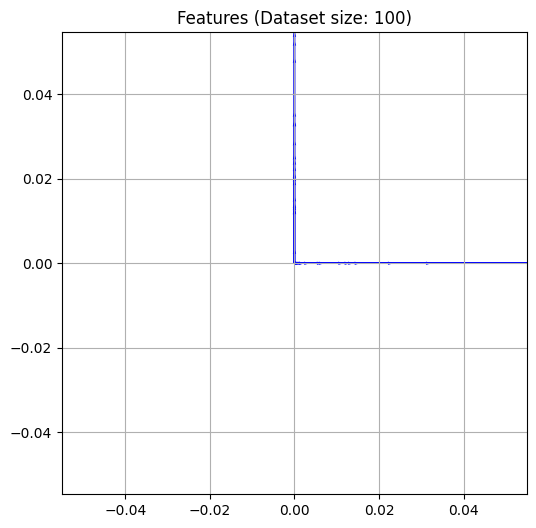

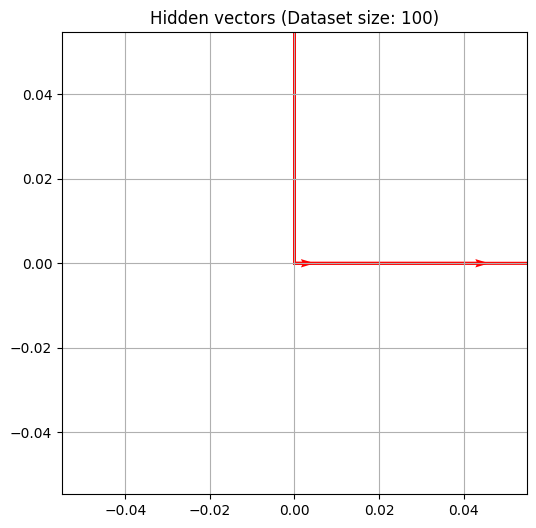

Training epoch (size: 200): 100%|██████████| 50000/50000 [00:57<00:00, 864.66it/s]


Dataset size: 200, Best Test Loss: 0.001099873217754066


Training epoch (size: 500): 100%|██████████| 50000/50000 [01:25<00:00, 586.43it/s]


Dataset size: 500, Best Test Loss: 0.0010992056922987103


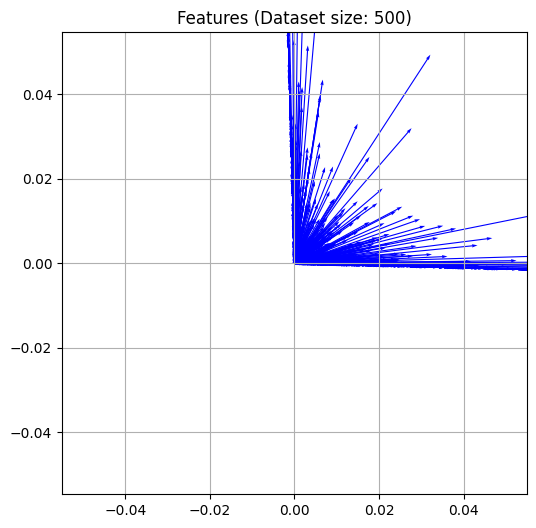

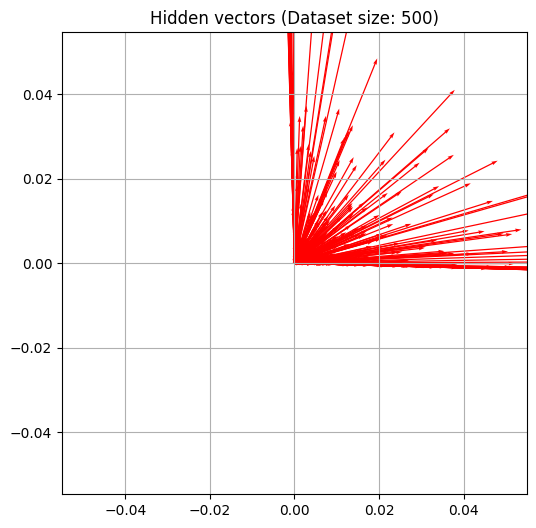

Training epoch (size: 1000): 100%|██████████| 50000/50000 [02:37<00:00, 316.48it/s]


Dataset size: 1000, Best Test Loss: 0.0010999457444995642


Training epoch (size: 2000): 100%|██████████| 50000/50000 [05:28<00:00, 152.04it/s]


Dataset size: 2000, Best Test Loss: 0.0010999449295923114


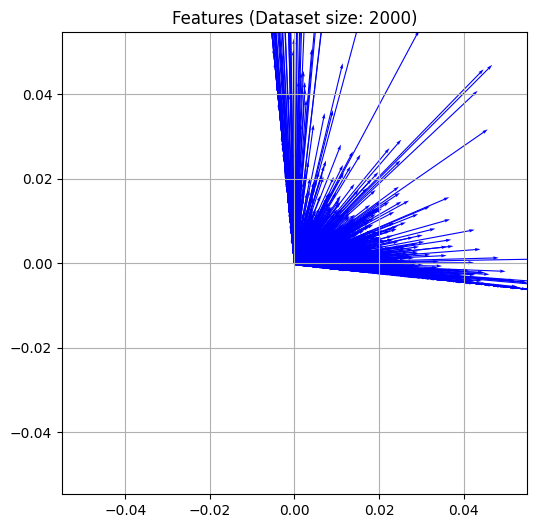

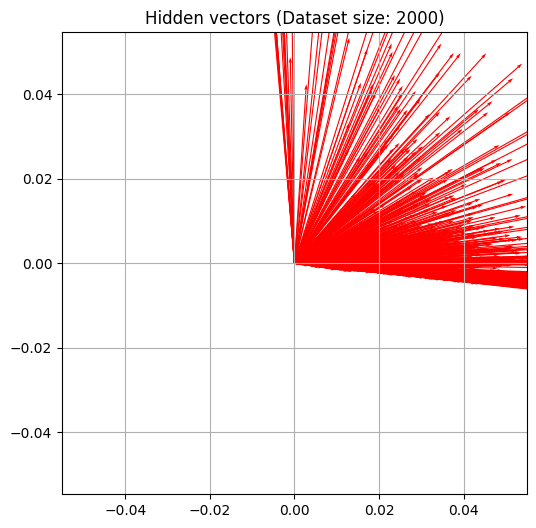

Training epoch (size: 5000): 100%|██████████| 50000/50000 [13:17<00:00, 62.69it/s]


Dataset size: 5000, Best Test Loss: 0.001099816639907658


Training epoch (size: 10000): 100%|██████████| 50000/50000 [27:22<00:00, 30.43it/s]


Dataset size: 10000, Best Test Loss: 0.001099713728763163


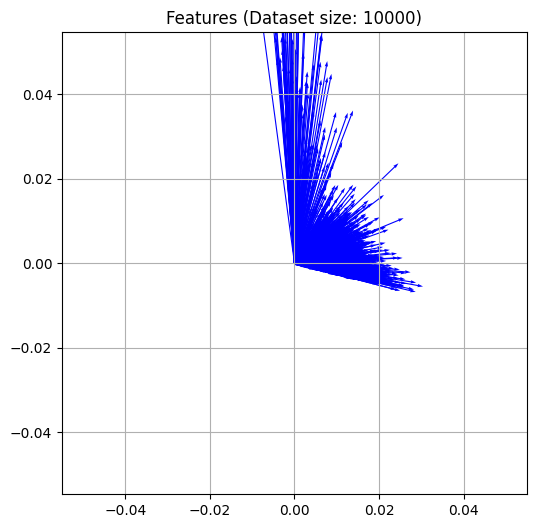

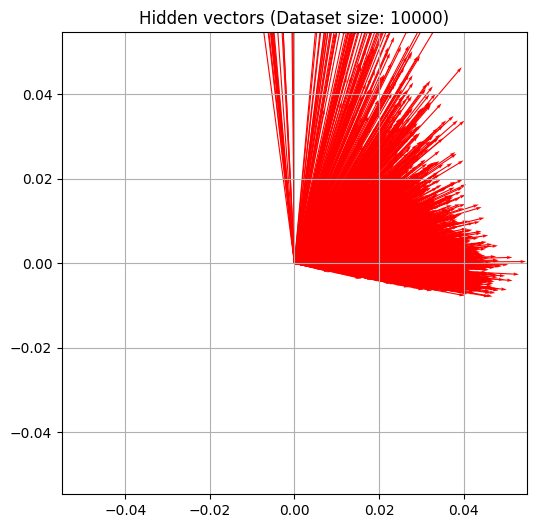

In [8]:
for n in dataset_sizes:
    X = generate_dataset(n, input_dim).to(device)

    min_loss = float('inf')
    best_model = None
    best_optimizer = None
    best_scheduler = None

    for seed in [0, 1, 2]:
        torch.manual_seed(seed)
        model = ReLUOutputModel(input_dim, hidden_dim).to(device)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        def lr_lambda(step):
            if step < warmup_steps:
                return float(step) / float(max(1, warmup_steps))
            return max(0.0, 0.5 * (1. + np.cos(np.pi * (step - warmup_steps) / (cosine_decay_steps - warmup_steps))))

        scheduler = LambdaLR(optimizer, lr_lambda)

        for epoch in tqdm(range(50000), desc=f"Training epoch (size: {n})"):
            optimizer.zero_grad()
            loss = F.mse_loss(model(X), X)
            loss.backward()
            optimizer.step()
            scheduler.step()

        test_loss = compute_loss(model, X_test)
        current_weight_norm = model.W.norm().item()
        current_bias_norm = model.b.norm().item()

        if test_loss < min_loss:
            min_loss = test_loss
            best_model = model
            best_optimizer = optimizer
            best_scheduler = scheduler
            best_weight_norm = current_weight_norm
            best_bias_norm = current_bias_norm

    losses.append(min_loss)
    weight_norms.append(best_weight_norm)
    bias_norms.append(best_bias_norm)
    print(f"Dataset size: {n}, Best Test Loss: {min_loss}")

    if n in selected_sizes:
        plot_superposition(best_model, X, title_suffix=f"(Dataset size: {n})", device=device)

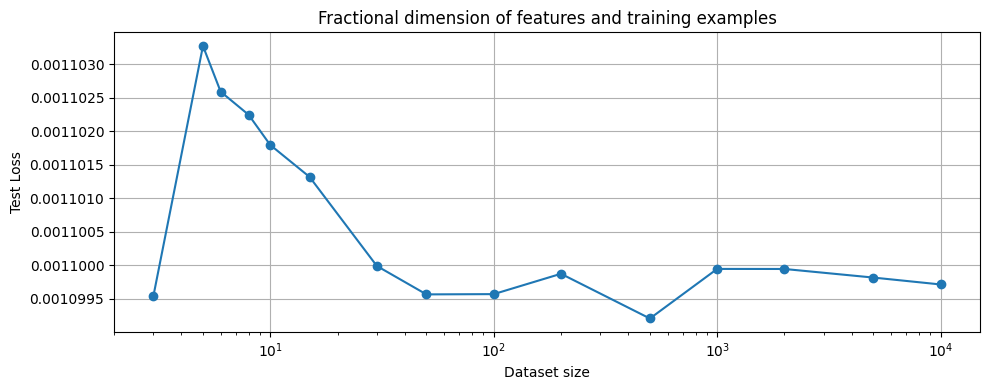

In [9]:
plot_fractional_dimension(losses, dataset_sizes)

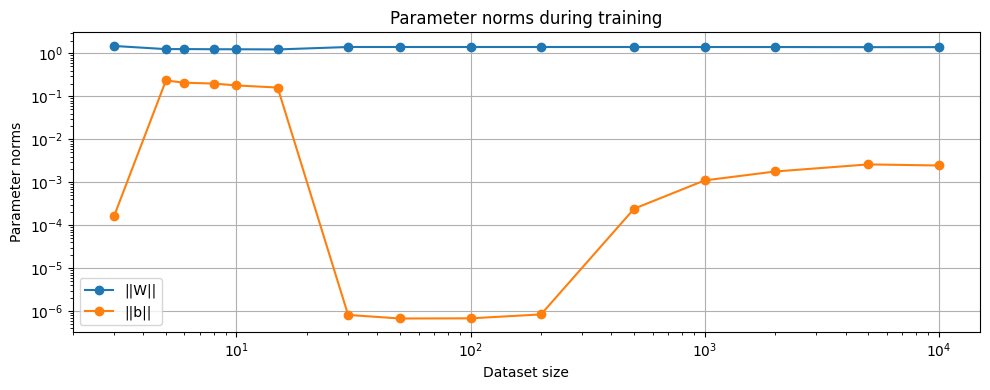

In [10]:
plot_parameter_norms(weight_norms, bias_norms, dataset_sizes)

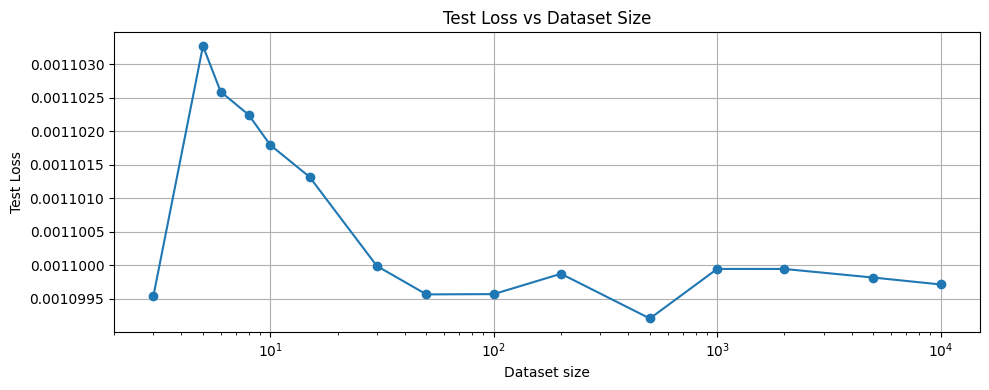

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(dataset_sizes, losses, marker='o')
plt.xscale('log')
plt.xlabel('Dataset size')
plt.ylabel('Test Loss')
plt.title('Test Loss vs Dataset Size')
plt.grid(True)
plt.tight_layout()
plt.show()